<a href="https://colab.research.google.com/github/kommurisi/Individual_SiddiKommuri_HandlingMissingData-Titanic/blob/main/Siddi_GenAI_WrittenSection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crash Course in Generative AI — From VAEs & GANs to Tiny Transformers

**Author:** Siddi Kommuri

This chapter introduces core generative modeling families (VAEs, GANs, Diffusion intuition, and Transformers), with **minimal, runnable PyTorch demos** on open datasets. You’ll learn how these models are built, trained, and evaluated — and where they shine in real applications.


## Abstract

Generative AI models learn data distributions to **sample** new content. We cover:
- **Foundations:** Latent-variable models (VAEs), adversarial training (GANs), denoising intuition (Diffusion), and sequence modeling (Transformers).
- **Architectures & training:** Encoders/Decoders, reparameterization, adversarial losses, and attention.
- **Evaluation:** Log-likelihood proxies (ELBO), FID/Inception Score, precision–recall for generative models, perplexity for LMs, and qualitative diagnostics.
- **Hands-on:** Implement a **VAE** and **DCGAN** on MNIST, plus a **tiny character-level Transformer** trained on a small text sample. We visualize reconstructions/samples and report simple metrics.


## Theory Section

### 1) Generative model families
- **VAEs (Variational Autoencoders):** Latent-variable models optimize a variational lower bound (ELBO). Use a **reparameterization trick** to backprop through sampling. Pros: stable training; Cons: blurrier samples.
- **GANs (Generative Adversarial Networks):** Generator vs Discriminator in a minimax game. Great visual fidelity; sensitive training (mode collapse, instability).
- **Diffusion models (intuition):** Learn to **denoise** data corrupted through a noise schedule. Reverse the noising process to sample. Excellent image quality; slower sampling (can be accelerated).
- **Transformers (autoregressive LMs):** Self-attention predicts tokens sequentially (next-token probability). Scale well; strong text/image/video generation (with tokenizers).

### 2) Architectures & pieces
- **Encoders/Decoders:** CNNs (images) / MLPs (toy data). Latent vector `z ~ N(0, I)` for VAEs & GANs.
- **Losses:**  
  - VAE: `recon_loss + KL(q(z|x) || p(z))` (ELBO)  
  - GAN: adversarial loss (e.g., non-saturating BCE)  
  - Diffusion (denoising): MSE to predict noise/clean data  
  - LM: cross-entropy over tokens
- **Optimization:** Adam/AdamW, lr scheduling, gradient clipping for stability.

### 3) Training methodology & challenges
- **VAEs:** balance KL vs reconstruction (β-VAE); avoid posterior collapse.  
- **GANs:** discriminator/generator capacity balance, label smoothing, spectral norm, data augmentation.  
- **Diffusion:** noise schedules (linear/cosine), classifier-free guidance (advanced).  
- **Transformers:** context length, batching by sequence, efficient masking.

### 4) Evaluation metrics (practical)
- **Images:** FID/IS (needs Inception features), classifier-based accuracy, human eval.  
- **Likelihood proxies:** ELBO for VAEs.  
- **Language:** Perplexity (exp of cross-entropy), downstream task accuracy.  
- **Qualitative diagnostics:** sample grids, reconstructions, interpolation, diversity checks.

> Ethics: Generative models can memorize or synthesize deceptive/biased content. Always consider licensing, consent, attribution, and safe deployment practices.


In [ ]:
# Colab-friendly: PyTorch & torchvision are preinstalled in most runtimes.
# If your Colab is bare, uncomment these:
# !pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cpu

import math, random, os, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

def show_grid(tensor, nrow=8, title=None):
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(grid.permute(1,2,0))
    plt.show()


Device: cpu


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 170kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


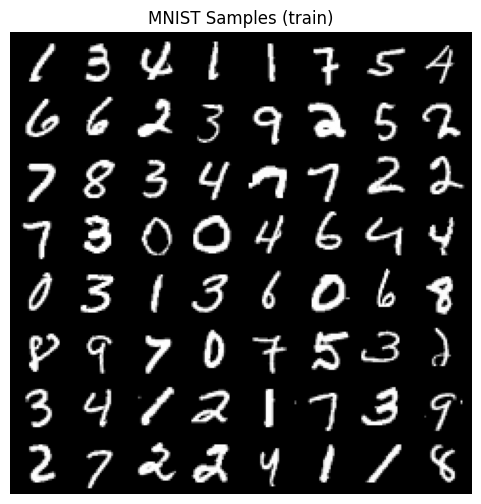

Chars: 62


In [ ]:
# ----- Image data: MNIST (auto-download) -----
tfm = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True,  download=True, transform=tfm)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=tfm)

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(mnist_test,  batch_size=batch_size, shuffle=False, drop_last=False)

# Peek at a batch
imgs,_ = next(iter(train_loader))
show_grid(imgs[:64], nrow=8, title="MNIST Samples (train)")

# ----- Tiny text dataset (Shakespeare tiny sample via URL) -----
import urllib.request
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
path = "./tiny.txt"
if not os.path.exists(path):
    urllib.request.urlretrieve(url, path)

with open(path, 'r', encoding='utf-8') as f:
    text = f.read()

# Keep a short slice for speed in demos
text = text[:300_000]
vocab = sorted(list(set(text)))
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(vocab)
print("Chars:", vocab_size)

def encode(s): return torch.tensor([stoi[c] for c in s], dtype=torch.long)
def decode(t): return ''.join([itos[i] for i in t.tolist()])
data = encode(text)


### VAE on MNIST (Convolutional)

- **Encoder** outputs `μ(x), logσ²(x)` for a Gaussian `q(z|x)`; sample `z = μ + σ ⊙ ε`.  
- **Decoder** maps `z → x̂` (Bernoulli logits for MNIST).  
- **Loss = reconstruction (BCE) + KL divergence** to `N(0, I)`.  
We’ll train for a few epochs to get reasonable **reconstructions** and **random samples**.


Epoch 1: loss=182.533  recon=176.716  kl=5.817
Epoch 2: loss=129.791  recon=116.678  kl=13.113
Epoch 3: loss=117.869  recon=102.730  kl=15.139
Epoch 4: loss=114.203  recon=98.614  kl=15.589
Epoch 5: loss=112.377  recon=96.541  kl=15.836


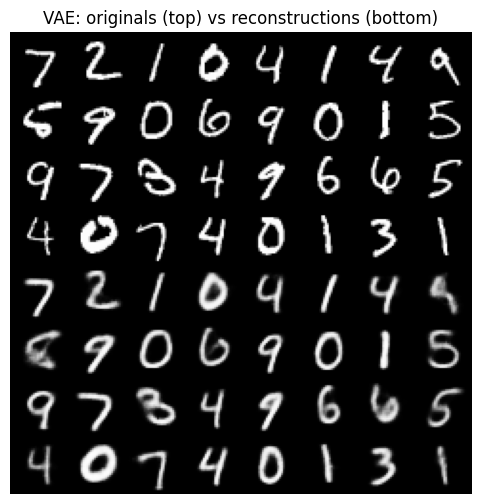

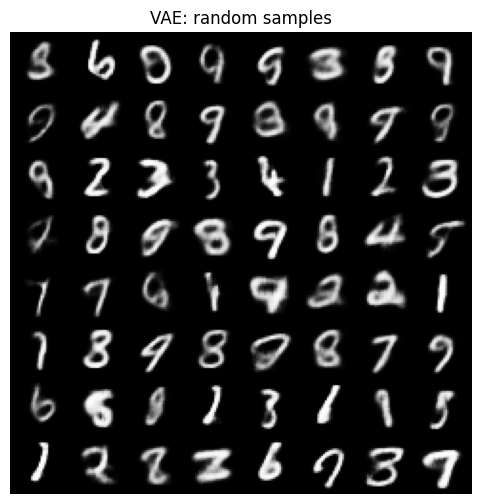

In [ ]:
class Encoder(nn.Module):
    def __init__(self, zdim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,4,2,1), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU()
        )
        self.mu = nn.Linear(256, zdim)
        self.logvar = nn.Linear(256, zdim)
    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, zdim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, 256), nn.ReLU(),
            nn.Linear(256, 64*7*7), nn.ReLU(),
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(32,1,4,2,1)
        )
    def forward(self, z):
        return self.net(z)  # logits

class VAE(nn.Module):
    def __init__(self, zdim=16):
        super().__init__()
        self.enc = Encoder(zdim)
        self.dec = Decoder(zdim)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparam(mu, logvar)
        logits = self.dec(z)
        return logits, mu, logvar

def vae_loss(x, logits, mu, logvar):
    recon = F.binary_cross_entropy_with_logits(logits, x, reduction='sum') / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon + kl, recon, kl

vae = VAE(zdim=16).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=2e-3)

epochs = 5  # bump to 15–20 for better quality
vae.train()
for ep in range(1, epochs+1):
    tot, rec, klv = 0,0,0
    for xb,_ in train_loader:
        xb = xb.to(device)
        opt.zero_grad()
        logits, mu, logvar = vae(xb)
        loss, r, k = vae_loss(xb, logits, mu, logvar)
        loss.backward(); opt.step()
        tot += loss.item(); rec += r.item(); klv += k.item()
    print(f"Epoch {ep}: loss={tot/len(train_loader):.3f}  recon={rec/len(train_loader):.3f}  kl={klv/len(train_loader):.3f}")

# Reconstructions
vae.eval()
xb,_ = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    logits,_,_ = vae(xb)
    xhat = torch.sigmoid(logits)
show_grid(torch.cat([xb[:32], xhat[:32]], dim=0), nrow=8, title="VAE: originals (top) vs reconstructions (bottom)")

# Random samples
with torch.no_grad():
    z = torch.randn(64, 16, device=device)
    logits = vae.dec(z)
    samples = torch.sigmoid(logits)
show_grid(samples, nrow=8, title="VAE: random samples")


### DCGAN on MNIST (fast demo)

- **Generator** maps noise `z ~ N(0,1)` to a 1×28×28 image via transposed convolutions.  
- **Discriminator** scores real vs fake (BCE loss).  
We’ll train briefly (a few epochs) for recognizable digits.


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.99MB/s]


Epoch 1: D=0.236  G=2.429
Epoch 2: D=0.645  G=6.414
Epoch 3: D=0.366  G=2.568
Epoch 4: D=0.245  G=2.971
Epoch 5: D=0.445  G=7.264


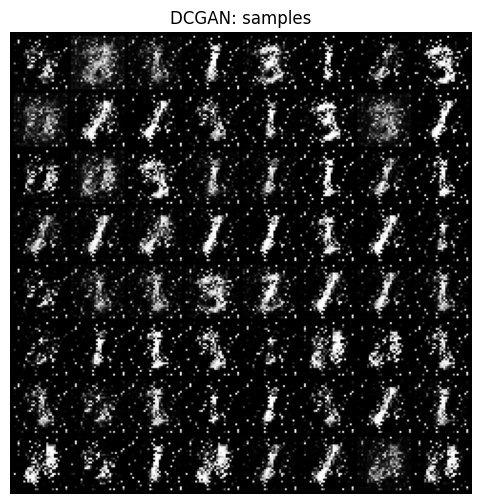

In [3]:
# --- Self-contained DCGAN demo (safe to run alone) ---

# Imports (in case the setup cell wasn't run)
import os, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper: show a grid (define if missing)
def show_grid(tensor, nrow=8, title=None):
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    plt.figure(figsize=(6,6)); plt.axis('off')
    if title: plt.title(title)
    plt.imshow(grid.permute(1,2,0)); plt.show()

# Data (define if train_loader not present)
try:
    train_loader
except NameError:
    tfm = transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=tfm)
    train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, drop_last=True)

# --- DCGAN (light MLP variant for speed) ---
nz = 64  # latent size

class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 256), nn.ReLU(True),
            nn.Linear(256, 512), nn.ReLU(True),
            nn.Linear(512, 1*28*28), nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1,1,28,28)

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*28*28, 512), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

gen = G().to(device)
dis = D().to(device)
opt_g = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_d = torch.optim.Adam(dis.parameters(), lr=2e-4, betas=(0.5,0.999))

def bce_with_logits(pred, target):
    return F.binary_cross_entropy_with_logits(pred, target)

epochs = 5  # bump to 20+ for better results
for ep in range(1, epochs+1):
    for real,_ in train_loader:
        real = (real.to(device)*2-1)  # scale to [-1,1]
        bs = real.size(0)

        # Train D
        z = torch.randn(bs, nz, device=device)
        fake = gen(z).detach()
        d_real = dis(real)
        d_fake = dis(fake)
        loss_d = bce_with_logits(d_real, torch.ones_like(d_real)) + \
                 bce_with_logits(d_fake, torch.zeros_like(d_fake))
        opt_d.zero_grad(); loss_d.backward(); opt_d.step()

        # Train G
        z = torch.randn(bs, nz, device=device)
        fake = gen(z)
        d_fake = dis(fake)
        loss_g = bce_with_logits(d_fake, torch.ones_like(d_fake))
        opt_g.zero_grad(); loss_g.backward(); opt_g.step()

    print(f"Epoch {ep}: D={loss_d.item():.3f}  G={loss_g.item():.3f}")

# Samples
gen.eval()
with torch.no_grad():
    z = torch.randn(64, nz, device=device)
    fake = gen(z)
show_grid((fake+1)/2, title="DCGAN: samples")


### Tiny Transformer (character-level) — next-token prediction

- Tokenize characters; train a small Transformer on a tiny Shakespeare subset.  
- Optimize cross-entropy; evaluate **perplexity** on a held-out slice.  
- Generate text via greedy or top-k sampling.


In [5]:
# ---- Tiny Transformer LM (self-contained) ----
import math, os, urllib.request
import torch, torch.nn as nn, torch.nn.functional as F

# If text/vocab are missing, load Tiny Shakespeare and build encoding now
try:
    data, stoi, itos, vocab_size
except NameError:
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    path = "./tiny.txt"
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()
    text = text[:300_000]  # keep a slice for speed
    vocab = sorted(list(set(text)))
    stoi = {ch:i for i,ch in enumerate(vocab)}
    itos = {i:ch for i,ch in enumerate(vocab)}
    vocab_size = len(vocab)
    def encode(s): return torch.tensor([stoi[c] for c in s], dtype=torch.long)
    def decode(t): return ''.join([itos[i] for i in t.tolist()])
    data = encode(text)

# ---------- data split


### (Optional) Diffusion intuition on 2-D toy data

To keep runtime light, we visualize **forward noising** and **simple denoising** on 2-D Gaussians (not a full image diffusion). This conveys the idea of a noise schedule and a model that predicts noise to reverse it.


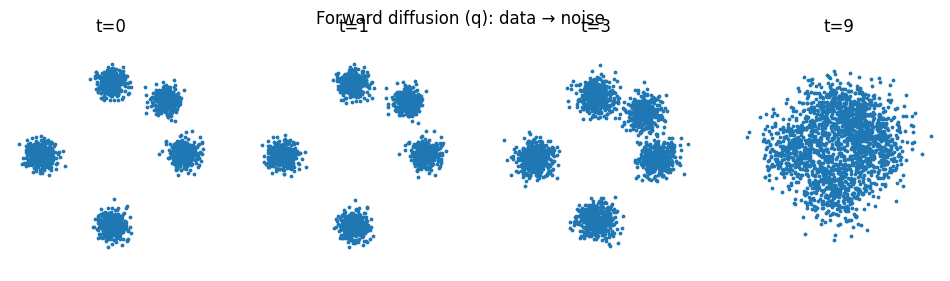

In [6]:
import matplotlib.pyplot as plt

# Toy dataset: mixture of Gaussians
def sample_mog(n=2048):
    centers = torch.tensor([[2,0],[-2,0],[0,2],[0,-2],[1.5,1.5]], dtype=torch.float32)
    i = torch.randint(0, centers.size(0), (n,))
    x = centers[i] + 0.2*torch.randn(n,2)
    return x

x0 = sample_mog(2000)
T = 10  # steps
betas = torch.linspace(1e-3, 0.15, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

# Forward noising q(x_t | x_{t-1})
xs = [x0]
xt = x0.clone()
for t in range(T):
    noise = torch.randn_like(xt) * betas[t].sqrt()
    xt = alphas[t].sqrt()*xt + noise
    xs.append(xt)

# Plot few steps
plt.figure(figsize=(12,3))
for i,step in enumerate([0,1,3,9]):
    plt.subplot(1,4,i+1); plt.scatter(xs[step][:,0], xs[step][:,1], s=3)
    plt.title(f"t={step}"); plt.axis('equal'); plt.axis('off')
plt.suptitle("Forward diffusion (q): data → noise"); plt.show()


## Generative modeling in a probabilistic nutshell

Goal: learn a distribution \(p_{\text{data}}(x)\) and draw new samples \(x \sim p_\theta(x)\).

- **Explicit density**: model \(p_\theta(x)\) directly and train by maximum likelihood (autoregressive models; normalizing flows).
- **Implicit density**: define a sampler \(x = G_\theta(z)\) with \(z \sim p(z)\); the density is intractable but sampling is easy (GANs).
- **Latent-variable models**: introduce \(z \sim p(z)\) and condition \(x \sim p_\theta(x\mid z)\); learn with variational inference (VAEs).
- **Score-based / diffusion**: learn to denoise/noise-score and integrate a reverse-time SDE to sample.


## Variational Autoencoders (VAEs)

- Assume a prior \(p(z)=\mathcal N(0, I)\) and decoder \(p_\theta(x\mid z)\).  
- Introduce an encoder \(q_\phi(z\mid x)\) to approximate the true posterior.  
- Optimize the **ELBO**:
\[
\log p_\theta(x) \ge \mathbb E_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]
- \mathrm{KL}\big(q_\phi(z\mid x)\,\|\,p(z)\big)
\]
- **Reparameterization trick**: sample \(z = \mu(x) + \sigma(x)\odot \epsilon\), \(\epsilon\sim \mathcal N(0,I)\) to backprop through sampling.
- Practical notes: tune the KL weight (β-VAE), watch for posterior collapse, inspect reconstructions and latent traversals.


## GANs in one page

- Two networks: **Generator** \(G_\theta(z)\) and **Discriminator** \(D_\psi(x)\).  
- Objective (non-saturating form):  
  - Discriminator maximizes \(\log D(x) + \log(1-D(G(z)))\).  
  - Generator maximizes \(\log D(G(z))\) (equivalently, minimizes \(-\log D(G(z))\)).
- Intuition: \(D\) learns a critic; \(G\) learns to fool it so the generated distribution matches data.
- Stability toolkit: label smoothing, spectral norm/gradient penalty, balanced capacity, data augmentation, careful learning rates.
- Failure modes: mode collapse (low diversity), training oscillation. Always monitor sample grids and diversity metrics.


## Diffusion intuition

- Forward process: gradually add Gaussian noise \(q(x_t\mid x_{t-1})\) until data becomes pure noise.  
- Reverse process: learn a denoiser \(\epsilon_\theta(x_t,t)\) (or score \(\nabla_x \log p(x_t)\)) and step backward \(T\to 0\) to generate samples.
- Loss: simple MSE between true noise and predicted noise at step \(t\).  
- Tradeoffs: state-of-the-art image quality and diversity; sampling speed improved with better solvers and distillation.


## Autoregressive Transformers (text)

- Factorize likelihood: \(p(x)=\prod_t p(x_t\mid x_{<t})\).  
- Self-attention builds contextual representations with causal masks; optimize cross-entropy (next-token prediction).  
- **Perplexity** \(=\exp(\text{cross-entropy})\) is a standard quality metric.  
- Sampling controls: temperature, top-k/p, repetition penalties; prompts condition the generation.


## How to evaluate generative models

- **Likelihood/ELBO** (VAEs; autoregressive): training objective correlates with sample quality when model fits well.  
- **Image quality/diversity**: FID, Inception Score, Precision–Recall for generative models, classifier-based accuracy on downstream tasks.  
- **Language**: perplexity on held-out text; human evaluation for coherence, helpfulness, safety.  
- **Qualitative**: reconstructions vs inputs, random samples, interpolations, nearest-neighbor checks for memorization.


## Training pragmatics

- Data matters most: correct normalization, balanced classes, strong augmentation (for images), deduplication to reduce memorization.  
- Optimization: Adam/AdamW, weight decay, gradient clipping, warmup + cosine decay; mixed precision for speed.  
- Regularization: dropout/LayerNorm (Transformers), KL control (VAEs), spectral norm/GP (GANs).  
- Monitoring: loss curves (and components), sample grids every N steps, validation perplexity/FID, learning-rate finder.


## Safety, licensing, and responsible use

- **Memorization & privacy**: avoid training on sensitive data; consider deduplication and auditing.  
- **Bias & fairness**: training data reflects society’s biases; evaluate and mitigate with filtering and alignment.  
- **Attribution & licenses**: respect dataset/model licenses; document sources and permissible uses.  
- **Misuse**: watermarking, content filters, policy guardrails, and disclosure when content is AI-generated.


## When to pick which model

- Need an interpretable latent space or reconstructions → **VAE** (or β-VAE).  
- Need sharp, photo-realistic images with limited compute → well-tuned **GAN**.  
- Need SOTA image fidelity/diversity and can afford sampling cost → **Diffusion**.  
- Need text/code/audio sequence generation or conditioning on prompts → **Autoregressive Transformer**.


## Quick checklist for experiments

1) Define task & metrics (e.g., ELBO/FID/perplexity).  
2) Prepare data + licensing; split train/val; log preprocessing.  
3) Start with a small model/batch to confirm the loop; overfit a tiny subset to sanity-check.  
4) Scale training; track samples and metrics; checkpoint often.  
5) Evaluate vs baselines; run qualitative audits; document limitations and risks.


## Conclusion

- **VAEs** learn latent representations with stable training and clear likelihood objectives (ELBO).  
- **GANs** produce sharp samples but require careful training tricks and monitoring.  
- **Transformers** unify sequence modeling; even tiny models learn coherent local structure.  
- **Diffusion** (conceptually) reframes generation as denoising; modern SOTA for images.  

**Practice tips:** monitor losses and reconstructions, track sample diversity (avoid collapse), and benchmark against simple baselines. Always consider licenses and ethics when training/using generative models.


## References

- Kingma & Welling (2014). Auto-Encoding Variational Bayes.  
- Goodfellow et al. (2014). Generative Adversarial Networks.  
- Ho et al. (2020). Denoising Diffusion Probabilistic Models.  
- Vaswani et al. (2017). Attention Is All You Need.  
- Salimans et al. (2016). Improved Techniques for Training GANs.  
- Oord et al. (2017). Parallel WaveNet / PixelCNN++ (autoregressive density models).  
- PyTorch docs: https://pytorch.org/  
- TorchVision datasets: https://pytorch.org/vision/stable/datasets.html


## License

All original code in this notebook is released under the **MIT License** by _Your Name_.  
Datasets used (MNIST, Tiny Shakespeare text) are provided by their respective owners under their original licenses.
